In [1]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import os

import src.utils as utils
from src.model import Nonneg_dagma, MetMulDagma

from baselines.colide import colide_ev
from baselines.dagma_linear import DAGMA_linear
from baselines.notears import notears_linear


PATH = './results/samples/'
SAVE = True 
SEED = 10
N_CPUS = os.cpu_count()
np.random.seed(SEED)

## Auxiliary functions

In [2]:
# Experiment function
def get_lamb_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def run_samples_exp(g, data_p, N_samples, exps, thr=.2, verb=False):
    shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = [np.zeros((len(N_samples), len(exps)))  for _ in range(8)]
    for i, n_samples in enumerate(N_samples):
        if g % N_CPUS == 0:
            print(f'Graph: {g+1}, samples: {n_samples}')

        # Create data
        data_p_aux = data_p.copy()
        data_p_aux['n_samples'] = n_samples

        W_true, _, X = utils.simulate_sem(**data_p_aux)
        X_std = utils.standarize(X)
        W_true_bin = utils.to_bin(W_true, thr)
        norm_W_true = np.linalg.norm(W_true)

        for j, exp in enumerate(exps):
            X_aux = X_std if 'standarize' in exp.keys() and exp['standarize'] else X


            arg_aux = exp['args'].copy()
            if 'adapt_lamb' in exp.keys() and exp['adapt_lamb']:
                if 'lamb' in arg_aux.keys():
                    arg_aux['lamb'] = get_lamb_value(data_p['n_nodes'], n_samples, arg_aux['lamb'])
                elif 'lambda1' in arg_aux.keys():
                    arg_aux['lambda1'] = get_lamb_value(data_p['n_nodes'], n_samples, arg_aux['lambda1'])

            if exp['model'] == notears_linear:
                t_init = perf_counter()
                W_est = notears_linear(X_aux, **arg_aux)
                t_end = perf_counter()
            else:
                model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
                t_init = perf_counter()
                model.fit(X_aux, **arg_aux)
                t_end = perf_counter()
                
                W_est = model.W_est

            if np.isnan(W_est).any():
                W_est = np.zeros_like(W_est)
                W_est_bin = np.zeros_like(W_est)
            else:
                W_est_bin = utils.to_bin(W_est, thr)
            
            shd[i,j], tpr[i,j], fdr[i,j] = utils.count_accuracy(W_true_bin, W_est_bin)
            fscore[i,j] = f1_score(W_true_bin.flatten(), W_est_bin.flatten())
            err[i,j] = utils.compute_norm_sq_err(W_true, W_est, norm_W_true)
            acyc[i,j] = model.dagness(W_est) if hasattr(model, 'dagness') else 1
            runtime[i,j] = t_end - t_init
            dag_count[i,j] += 1 if utils.is_dag(W_est_bin) else 0
        
            if verb and (g % N_CPUS == 0):
                print(f'\t\t-{exp["leg"]}: shd {shd[i,j]}  -  err: {err[i,j]:.3f}  -  time: {runtime[i,j]:.3f}')

    return shd, tpr, fdr, fscore, err, acyc, runtime, dag_count


## Without standarizing

In [3]:
n_dags = 50
N_samples = [50, 60, 80, 100, 200, 500, 1000, 5000]

# DEFINE EXPERIMENTS
Exps = [
  {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-1,
   'iters_in': 10000, 'iters_out': 10, 'beta': 2}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
   'adapt_lamb': True, 'standarize': False, 'fmt': 'o-', 'leg': 'MM-Logdet'},

  {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .05,
   'iters_in': 10000, 'iters_out': 10, 'beta': 2}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
   'adapt_lamb': False, 'standarize': False, 'fmt': 'o--', 'leg': 'MM-Logdet-fix'},

  {'model': MetMulDagma, 'args': {'stepsize': 1e-5, 'alpha_0': 1, 'rho_0': 10, 's': 1, 'lamb': .1, 'iters_in': 10000,
   'iters_out': 10, 'beta': 5, 'tol': 1e-5}, 'init': {'acyclicity': 'matexp', 'primal_opt': 'fista'}, 'standarize': False,
   'adapt_lamb': True, 'fmt': 'x-', 'leg': 'MM-Matexp'},

  # Colide
  {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
   'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': 'v--', 'leg': 'CoLiDe-Fix'},

  {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
   'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'adapt_lamb': True, 'fmt': 'v-', 'leg': 'CoLiDe'},

  # DAGMA
  {'model': DAGMA_linear, 'init': {'loss_type': 'l2'}, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .8],
   'warm_iter': 2e4, 'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': '^-', 'leg': 'DAGMA'},

  # NoTears
  {'model': notears_linear, 'args': {'loss_type': 'l2', 'lambda1': .1, 'max_iter': 4}, 'standarize': False,  'fmt': '>-', 'leg': 'NoTears'},
]

### 100 nodes - unit variance

In [4]:
N = 100
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results)


CPUs employed: 64


Graph: 8, samples: 50
Graph: 33, samples: 50
Graph: 34, samples: 50
Graph: 21, samples: 50
Graph: 47, samples: 50
Graph: 17, samples: 50
Graph: 19, samples: 50
Graph: 20, samples: 50
Graph: 24, samples: 50
Graph: 46, samples: 50
Graph: 1, samples: 50
Graph: 16, samples: 50
Graph: 18, samples: 50
Graph: 39, samples: 50
Graph: 41, samples: 50
Graph: 15, samples: 50
Graph: 32, samples: 50
Graph: 14, samples: 50
Graph: 5, samples: 50
Graph: 40, samples: 50
Graph: 44, samples: 50
Graph: 30, samples: 50
Graph: 29, samples: 50
Graph: 28, samples: 50
Graph: 31, samples: 50
Graph: 3, samples: 50
Graph: 42, samples: 50
Graph: 2, samples: 50
Graph: 37, samples: 50
Graph: 9, samples: 50
Graph: 43, samples: 50
Graph: 48, samples: 50
Graph: 7, samples: 50
Graph: 4, samples: 50
Graph: 36, samples: 50
Graph: 45, samples: 50
Graph: 49, samples: 50
Graph: 50, samples: 50
Graph: 12, samples: 50
Graph: 13, samples: 50
Graph: 38, samples: 50
Graph: 26, samples: 50
Graph: 25, samples: 50
Graph: 35, samples:

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 15, samples: 60
Graph: 47, samples: 60
Graph: 8, samples: 60
Graph: 43, samples: 60
Graph: 26, samples: 60
Graph: 9, samples: 60
Graph: 24, samples: 60
Graph: 44, samples: 60
Graph: 40, samples: 60
Graph: 2, samples: 60
Graph: 1, samples: 60
Graph: 28, samples: 60
Graph: 21, samples: 60
Graph: 18, samples: 60
Graph: 27, samples: 60
Graph: 45, samples: 60
Graph: 35, samples: 60
Graph: 30, samples: 60
Graph: 3, samples: 60
Graph: 39, samples: 60
Graph: 7, samples: 60
Graph: 13, samples: 60
Graph: 23, samples: 60
Graph: 19, samples: 60
Graph: 25, samples: 60
Graph: 34, samples: 60
Graph: 20, samples: 60
Graph: 5, samples: 60
Graph: 46, samples: 60
Graph: 32, samples: 60
Graph: 12, samples: 60
Graph: 4, samples: 60
Graph: 49, samples: 60
Graph: 42, samples: 60
Graph: 48, samples: 60
Graph: 36, samples: 80
Graph: 29, samples: 80
Graph: 50, samples: 80
Graph: 11, samples: 80
Graph: 10, samples: 80
Graph: 41, samples: 80
Graph: 22, samples: 80
Graph: 31, samples: 80
Graph: 37, samples:

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 2, samples: 100
Graph: 21, samples: 100
Graph: 8, samples: 100
Graph: 3, samples: 100
Graph: 35, samples: 100
Graph: 40, samples: 100
Graph: 36, samples: 200
Graph: 24, samples: 100
Graph: 16, samples: 100
Graph: 27, samples: 100
Graph: 25, samples: 100
Graph: 28, samples: 100
Graph: 4, samples: 100
Graph: 23, samples: 100
Graph: 39, samples: 100
Graph: 34, samples: 100
Graph: 29, samples: 200
Graph: 45, samples: 100
Graph: 11, samples: 200
Graph: 37, samples: 200
Graph: 32, samples: 100
Graph: 30, samples: 100
Graph: 38, samples: 100
Graph: 50, samples: 200
Graph: 5, samples: 100
Graph: 9, samples: 100
Graph: 19, samples: 100
Graph: 26, samples: 100
Graph: 41, samples: 200
Graph: 15, samples: 200
Graph: 1, samples: 100
Graph: 31, samples: 200
Graph: 17, samples: 200
Graph: 14, samples: 100
Graph: 46, samples: 100
Graph: 48, samples: 100
Graph: 13, samples: 100
Graph: 22, samples: 200
Graph: 10, samples: 200
Graph: 42, samples: 100
Graph: 49, samples: 100
Graph: 47, samples: 200

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 7, samples: 500
Graph: 29, samples: 1000
Graph: 30, samples: 500
Graph: 15, samples: 1000
Graph: 9, samples: 500
Graph: 4, samples: 500
Graph: 28, samples: 500
Graph: 18, samples: 1000
Graph: 39, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 5, samples: 500
Graph: 48, samples: 500
Graph: 44, samples: 500
Graph: 13, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 22, samples: 1000
Graph: 14, samples: 500
Graph: 1, samples: 500
Graph: 25, samples: 1000
Graph: 10, samples: 1000
Graph: 17, samples: 1000
Graph: 31, samples: 1000
Graph: 49, samples: 500
Graph: 11, samples: 1000
Graph: 16, samples: 500
Graph: 42, samples: 500
Graph: 36, samples: 5000
Graph: 47, samples: 1000
Graph: 24, samples: 1000
Graph: 33, samples: 1000
Graph: 6, samples: 1000
Graph: 20, samples: 1000
Graph: 45, samples: 1000
Graph: 8, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 46, samples: 500
Graph: 43, samples: 1000
Graph: 50, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 21, samples: 1000
Graph: 32, samples: 1000
Graph: 40, samples: 1000
Graph: 15, samples: 5000
Graph: 23, samples: 1000
Graph: 3, samples: 1000
Graph: 26, samples: 1000
Graph: 12, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 19, samples: 1000
Graph: 38, samples: 1000
Graph: 2, samples: 1000
Graph: 35, samples: 1000
Graph: 39, samples: 5000
Graph: 5, samples: 1000
Graph: 34, samples: 1000
Graph: 30, samples: 1000
Graph: 4, samples: 1000
Graph: 7, samples: 1000
Graph: 18, samples: 5000
Graph: 44, samples: 1000
Graph: 11, samples: 5000
Graph: 29, samples: 5000
Graph: 49, samples: 1000
Graph: 16, samples: 1000
Graph: 37, samples: 5000
Graph: 31, samples: 5000
Graph: 9, samples: 1000
Graph: 48, samples: 1000
Graph: 25, samples: 5000
Graph: 47, samples: 5000
Graph: 13, samples: 1000
Graph: 14, samples: 1000
Graph: 24, samples: 5000
Graph: 42, samples: 1000
Graph: 17, samples: 5000
Graph: 43, samples: 5000
Graph: 6, samples: 5000
Graph: 1, samples: 1000
Graph: 10, samples: 5000
Graph: 41, samples: 5000
Graph: 46, samples: 1000
Graph: 33, samples: 5000
Graph: 28, samples: 1000
Graph: 32, samples: 5000
Graph: 8, samples: 5000
Graph: 19, samples: 5000
Graph: 26, samples: 5000
Graph: 4, samples: 5000
Graph: 38

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 35, samples: 5000
Graph: 12, samples: 1000
Graph: 34, samples: 5000
Graph: 3, samples: 5000
Graph: 44, samples: 5000
Graph: 23, samples: 5000
Graph: 40, samples: 5000
Graph: 30, samples: 5000
Graph: 45, samples: 5000
Graph: 48, samples: 5000
Graph: 13, samples: 5000
Graph: 49, samples: 5000
Graph: 5, samples: 5000
Graph: 9, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 14, samples: 5000
Graph: 1, samples: 5000
Graph: 16, samples: 5000
Graph: 42, samples: 5000
Graph: 27, samples: 5000
Graph: 28, samples: 5000
Graph: 12, samples: 5000
Graph: 46, samples: 5000
----- Solved in 170.331 minutes -----


SAVED as: ./results/samples/samples_err_med.csv
SAVED as: ./results/samples/samples_err_prctile25.csv
SAVED as: ./results/samples/samples_err_prctile75.csv
SAVED as: ./results/samples/samples_shd_mean.csv
SAVED as: ./results/samples/samples_shd_std.csv


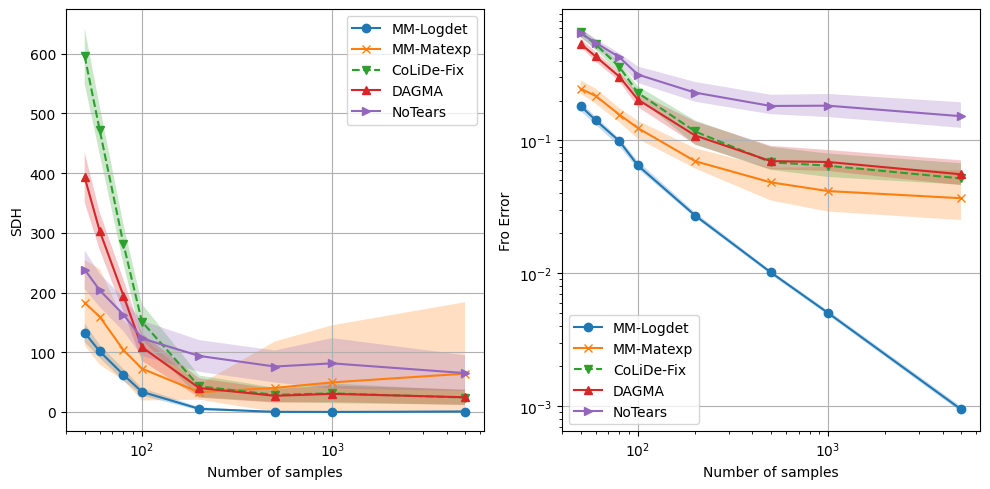

In [5]:
if SAVE:
    file_name = PATH + f'samples_{N}N_{int(data_p["edges"]/N)}'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=N_samples)
    print('SAVED in file:', file_name)

    agg_error = np.median(err, axis=0)
    utils.data_to_csv(f'{PATH}samples_err_med.csv', Exps, N_samples, agg_error)
    prctile25 = np.percentile(err, 25, axis=0)
    utils.data_to_csv(f'{PATH}samples_err_prctile25.csv', Exps, N_samples, prctile25)
    prctile75 = np.percentile(err, 75, axis=0)
    utils.data_to_csv(f'{PATH}samples_err_prctile75.csv', Exps, N_samples, prctile75)

    agg_shd = np.mean(err, axis=0)
    utils.data_to_csv(f'{PATH}samples_shd_mean.csv', Exps, N_samples, agg_shd)
    std_shd = np.std(err, axis=0)
    utils.data_to_csv(f'{PATH}samples_shd_std.csv', Exps, N_samples, std_shd)

skip = [1, 4]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
utils.plot_data(axes[0], shd, Exps, N_samples, 'Number of samples', 'SDH', skip,
                agg='mean', deviation='std', alpha=0.25)
utils.plot_data(axes[1], err, Exps, N_samples, 'Number of samples', 'Fro Error', skip,
                agg='median', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()



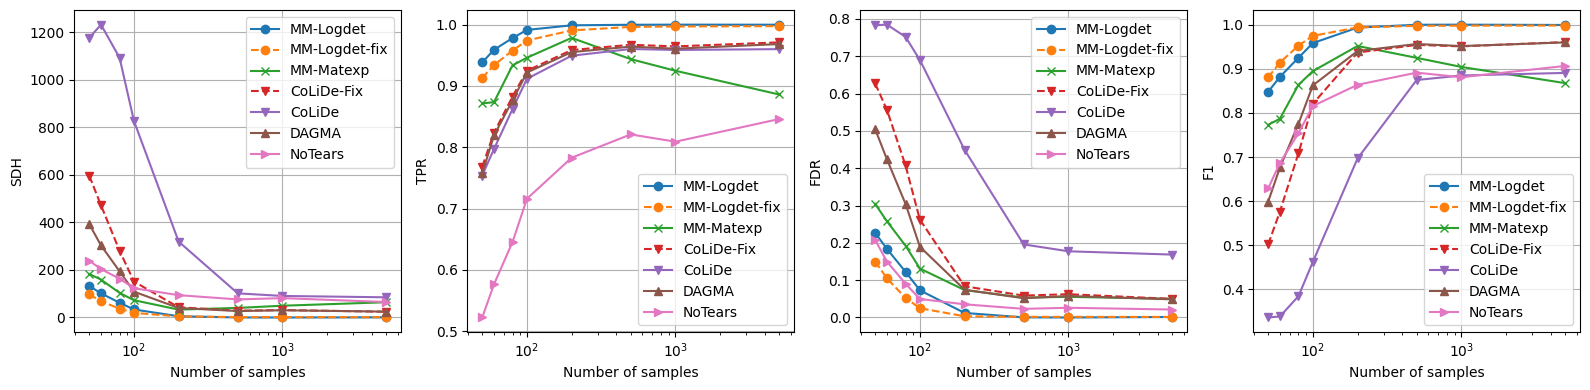

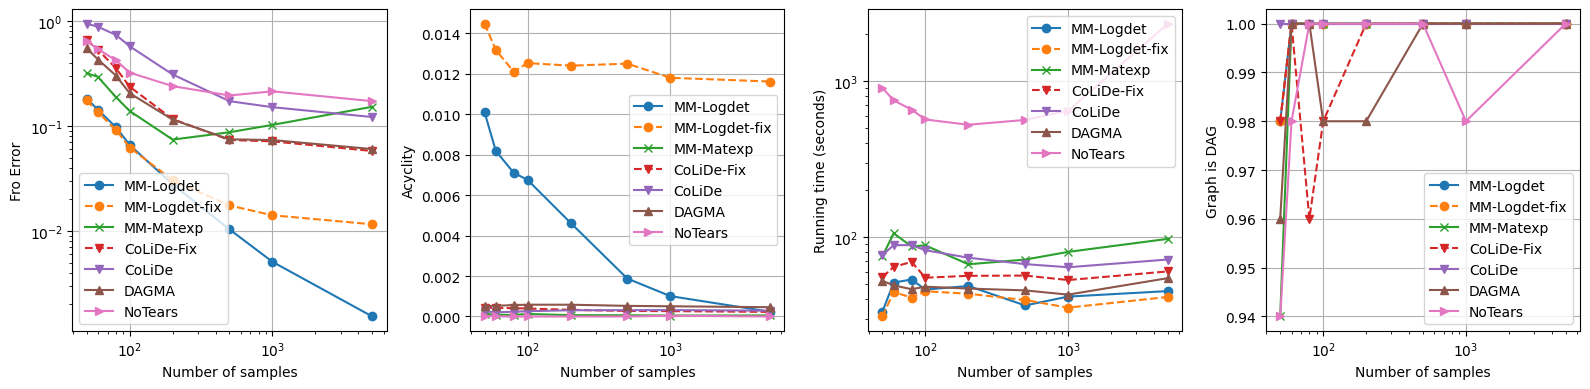

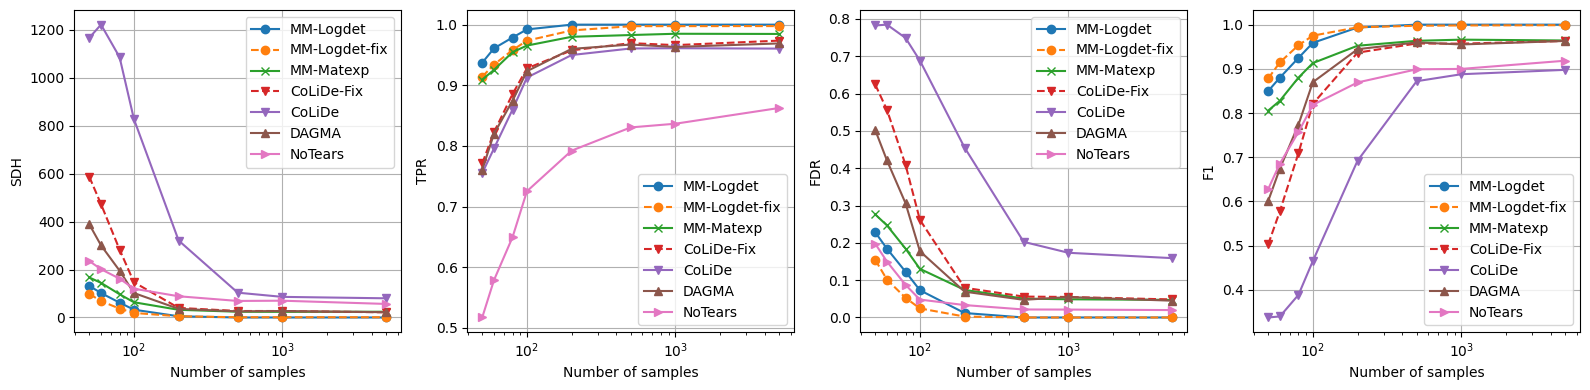

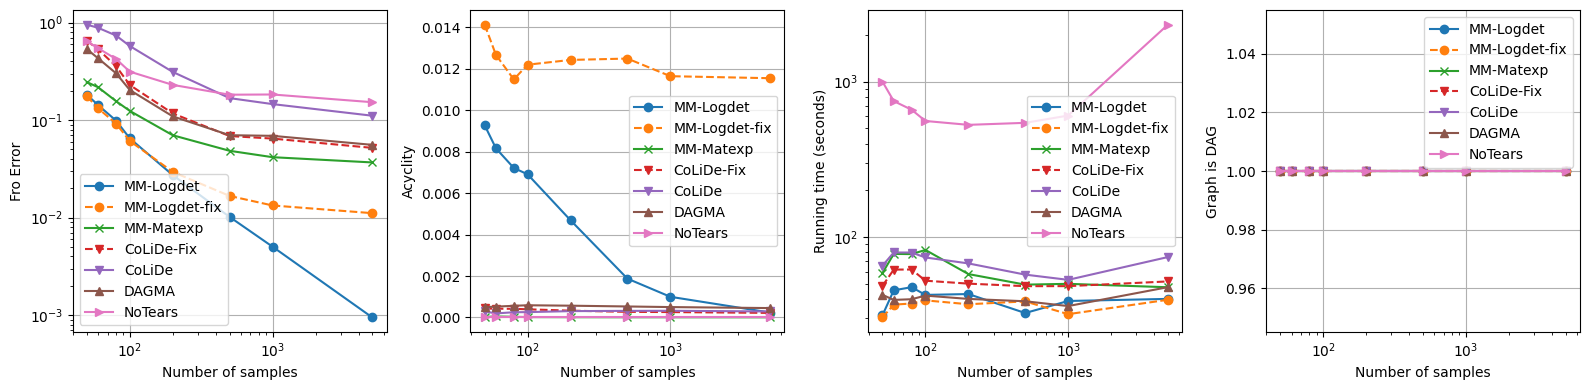

In [6]:
skip = [] # [2]
utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean')

utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='median')


In [3]:
# # Load Data
# file_name = "./results/samples/samples_4N.npz"
# data = np.load(file_name, allow_pickle=True)
# Exps = data['exps']
# shd = data['shd']
# err = data['err']
# N_samples = data['xvals']

### 2N Edges 

In [8]:
N = 100
thr = .2
verb = False
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
}


shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results)


CPUs employed: 64
Graph: 1, samples: 50
Graph: 2, samples: 50
Graph: 3, samples: 50
Graph: 4, samples: 50
Graph: 5, samples: 50
Graph: 6, samples: 50
Graph: 7, samples: 50
Graph: 8, samples: 50
Graph: 9, samples: 50
Graph: 10, samples: 50
Graph: 11, samples: 50
Graph: 12, samples: 50
Graph: 13, samples: 50
Graph: 14, samples: 50
Graph: 15, samples: 50
Graph: 16, samples: 50
Graph: 17, samples: 50
Graph: 18, samples: 50
Graph: 19, samples: 50
Graph: 20, samples: 50
Graph: 21, samples: 50
Graph: 22, samples: 50
Graph: 23, samples: 50
Graph: 24, samples: 50
Graph: 25, samples: 50
Graph: 26, samples: 50
Graph: 28, samples: 50
Graph: 29, samples: 50
Graph: 38, samples: 50
Graph: 40, samples: 50
Graph: 49, samples: 50
Graph: 30, samples: 50
Graph: 50, samples: 50
Graph: 32, samples: 50
Graph: 27, samples: 50
Graph: 31, samples: 50
Graph: 41, samples: 50
Graph: 37, samples: 50
Graph: 44, samples: 50
Graph: 47, samples: 50
Graph: 42, samples: 50
Graph: 46, samples: 50
Graph: 34, samples: 50
Gr

SAVED in file: ./results/samples/samples_100N_2


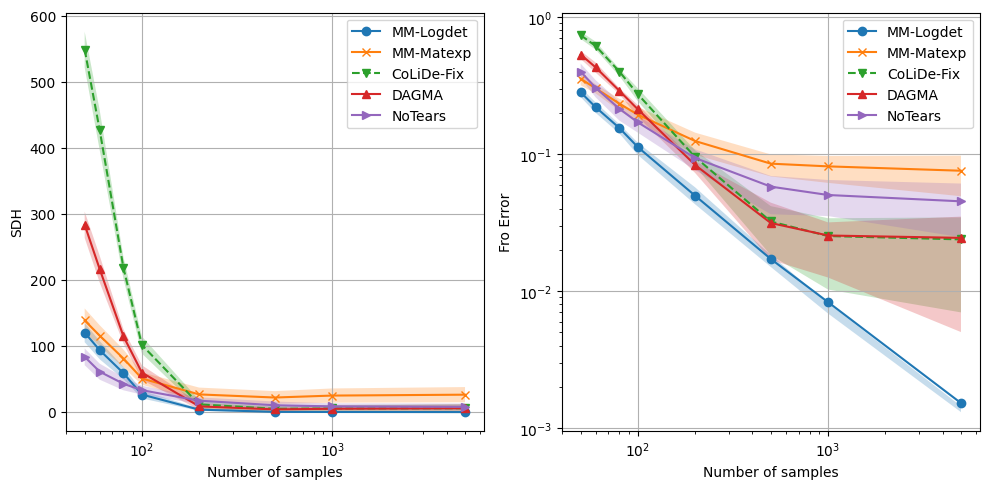

In [9]:
if SAVE:
    file_name = PATH + f'samples_{N}N_{int(data_p["edges"]/N)}'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=N_samples)
    print('SAVED in file:', file_name)
    
skip = [1, 4]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
utils.plot_data(axes[0], shd, Exps, N_samples, 'Number of samples', 'SDH', skip,
                agg='mean', deviation='std', alpha=0.25)
utils.plot_data(axes[1], err, Exps, N_samples, 'Number of samples', 'Fro Error', skip,
                agg='mean', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()


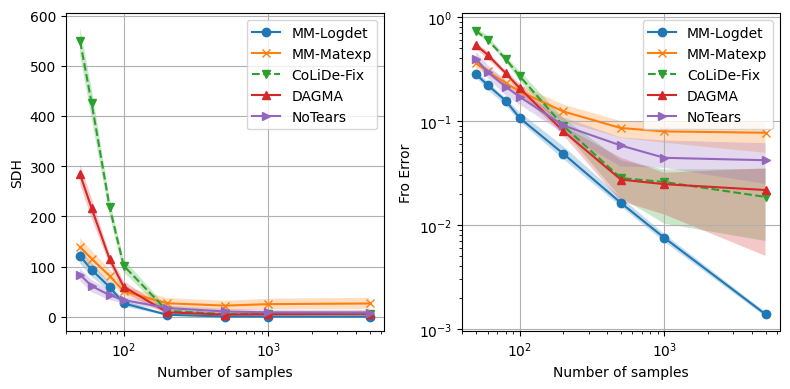

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
utils.plot_data(axes[0], shd, Exps, N_samples, 'Number of samples', 'SDH', skip,
                agg='mean', deviation='std', alpha=0.25)
utils.plot_data(axes[1], err, Exps, N_samples, 'Number of samples', 'Fro Error', skip,
                agg='median', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()


### 100 nodes - Larger edges

In [11]:
N = 100
thr = .2
verb = False
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1.5),
    'var': 1,
}


shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results)


CPUs employed: 64
Graph: 1, samples: 50
Graph: 2, samples: 50
Graph: 3, samples: 50
Graph: 4, samples: 50
Graph: 5, samples: 50
Graph: 6, samples: 50
Graph: 7, samples: 50
Graph: 8, samples: 50
Graph: 9, samples: 50
Graph: 10, samples: 50
Graph: 11, samples: 50
Graph: 12, samples: 50
Graph: 13, samples: 50
Graph: 14, samples: 50
Graph: 15, samples: 50
Graph: 16, samples: 50
Graph: 17, samples: 50
Graph: 18, samples: 50
Graph: 19, samples: 50
Graph: 20, samples: 50
Graph: 21, samples: 50
Graph: 22, samples: 50
Graph: 23, samples: 50
Graph: 24, samples: 50
Graph: 25, samples: 50
Graph: 26, samples: 50
Graph: 27, samples: 50
Graph: 28, samples: 50
Graph: 29, samples: 50
Graph: 30, samples: 50
Graph: 31, samples: 50
Graph: 32, samples: 50
Graph: 33, samples: 50
Graph: 34, samples: 50
Graph: 35, samples: 50
Graph: 36, samples: 50
Graph: 37, samples: 50
Graph: 38, samples: 50
Graph: 39, samples: 50
Graph: 40, samples: 50
Graph: 41, samples: 50
Graph: 42, samples: 50
Graph: 43, samples: 50
Gr

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invali

Graph: 48, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 23, samples: 60
Graph: 11, samples: 60
Graph: 5, samples: 60
Graph: 12, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 26, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 21, samples: 60
Graph: 37, samples: 60
Graph: 44, samples: 60
Graph: 28, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 36, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 25, samples: 60
Graph: 16, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 9, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 1, samples: 60
Graph: 18, samples: 60
Graph: 43, samples: 60
Graph: 15, samples: 60
Graph: 8, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/src/model.py:205: RuntimeWarning: overflow encountered in multiply
  return G_loss + (alpha + self.rho*acyc_val)*G_acyc
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 30, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 38, samples: 60
Graph: 3, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 6, samples: 60
Graph: 35, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 32, samples: 60
Graph: 20, samples: 60
Graph: 39, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 24, samples: 60
Graph: 42, samples: 60
Graph: 46, samples: 60
Graph: 45, samples: 60
Graph: 19, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 14, samples: 60
Graph: 27, samples: 60
Graph: 47, samples: 60
Graph: 41, samples: 60
Graph: 2, samples: 60
Graph: 50, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 33, samples: 60
Graph: 17, samples: 60
Graph: 31, samples: 60
Graph: 22, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: i

Graph: 49, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: i

Graph: 13, samples: 60
Graph: 10, samples: 60
Graph: 29, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: o

Graph: 7, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: i

Graph: 4, samples: 60
Graph: 34, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: i

Graph: 48, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 40, samples: 60


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 23, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 30, samples: 80
Graph: 5, samples: 80
Graph: 11, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: i

Graph: 12, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 16, samples: 80
Graph: 1, samples: 80
Graph: 26, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 14, samples: 80
Graph: 3, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 21, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 32, samples: 80
Graph: 28, samples: 80
Graph: 39, samples: 80
Graph: 9, samples: 80
Graph: 2, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 8, samples: 80
Graph: 45, samples: 80
Graph: 38, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 19, samples: 80
Graph: 44, samples: 80
Graph: 36, samples: 80
Graph: 10, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 31, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:1761: RuntimeWarning: invalid value encountered in reduce
  return asanyarray(a).trace(offset=offset, axis1=axis1, axis2=axis2, dtype=dtype, out=out)
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.ve

Graph: 27, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 46, samples: 80
Graph: 40, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 33, samples: 80
Graph: 25, samples: 80
Graph: 34, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 20, samples: 80
Graph: 43, samples: 80
Graph: 7, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 24, samples: 80
Graph: 47, samples: 80
Graph: 6, samples: 80
Graph: 42, samples: 80
Graph: 22, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 35, samples: 80
Graph: 18, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 13, samples: 80
Graph: 4, samples: 80
Graph: 37, samples: 80
Graph: 48, samples: 100
Graph: 17, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 12, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 30, samples: 100
Graph: 15, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 5, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: o

Graph: 49, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/src/model.py:205: RuntimeWarning: overflow encountered in scalar multiply
  return G_loss + (alpha + self.rho*acyc_val)*G_acyc


Graph: 29, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: i

Graph: 41, samples: 80
Graph: 23, samples: 100
Graph: 11, samples: 100
Graph: 50, samples: 80


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: i

Graph: 26, samples: 100
Graph: 21, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 32, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 14, samples: 100
Graph: 39, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 3, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 44, samples: 100
Graph: 9, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 16, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 38, samples: 100
Graph: 1, samples: 100
Graph: 37, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 2, samples: 100
Graph: 8, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 31, samples: 100
Graph: 28, samples: 100
Graph: 19, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: i

Graph: 36, samples: 100
Graph: 30, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 25, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 33, samples: 100
Graph: 43, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 6, samples: 100
Graph: 12, samples: 200
Graph: 45, samples: 100
Graph: 35, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 46, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 49, samples: 100
Graph: 40, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 13, samples: 100
Graph: 34, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 48, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 11, samples: 200
Graph: 20, samples: 100
Graph: 5, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 41, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 27, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 15, samples: 100
Graph: 18, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 17, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 4, samples: 100
Graph: 42, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/src/model.py:205: RuntimeWarning: overflow encountered in multiply
  return G_loss + (alpha + self.rho*acyc_val)*G_acyc
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encounte

Graph: 3, samples: 200
Graph: 22, samples: 100
Graph: 24, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 50, samples: 100
Graph: 32, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 47, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:1761: RuntimeWarning: invalid value encountered in reduce
  return asanyarray(a).trace(offset=offset, axis1=axis1, axis2=axis2, dtype=dtype, out=out)
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 26, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 7, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 23, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 39, samples: 200
Graph: 21, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 10, samples: 100
Graph: 14, samples: 200
Graph: 44, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: i

Graph: 29, samples: 100


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 16, samples: 200
Graph: 38, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 1, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 9, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 2, samples: 200
Graph: 36, samples: 200
Graph: 31, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 37, samples: 200
Graph: 28, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: i

Graph: 25, samples: 200
Graph: 8, samples: 200
Graph: 33, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 45, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 6, samples: 200
Graph: 47, samples: 200
Graph: 46, samples: 200
Graph: 42, samples: 200
Graph: 27, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 32, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 30, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 14, samples: 500
Graph: 12, samples: 500
Graph: 35, samples: 200
Graph: 17, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 43, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 13, samples: 200
Graph: 41, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 5, samples: 500
Graph: 24, samples: 200
Graph: 34, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 44, samples: 500
Graph: 4, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 19, samples: 200
Graph: 2, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 10, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 20, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 40, samples: 200
Graph: 18, samples: 200
Graph: 15, samples: 200
Graph: 22, samples: 200
Graph: 9, samples: 500
Graph: 29, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: o

Graph: 48, samples: 500
Graph: 26, samples: 500
Graph: 3, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 23, samples: 500
Graph: 1, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 11, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 37, samples: 500
Graph: 39, samples: 500
Graph: 47, samples: 500
Graph: 49, samples: 200
Graph: 16, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 7, samples: 200


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 28, samples: 500
Graph: 21, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 33, samples: 500
Graph: 31, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 50, samples: 200
Graph: 36, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: o

Graph: 25, samples: 500
Graph: 6, samples: 500
Graph: 46, samples: 500
Graph: 27, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: i

Graph: 45, samples: 500
Graph: 38, samples: 500
Graph: 14, samples: 1000
Graph: 42, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 13, samples: 500
Graph: 30, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 8, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 35, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 5, samples: 1000
Graph: 32, samples: 1000
Graph: 34, samples: 500
Graph: 2, samples: 1000
Graph: 41, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 12, samples: 1000
Graph: 20, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 40, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 17, samples: 500
Graph: 1, samples: 1000
Graph: 19, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: o

Graph: 29, samples: 500
Graph: 18, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 43, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 10, samples: 500
Graph: 22, samples: 500
Graph: 24, samples: 500
Graph: 50, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 16, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invali

Graph: 9, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 7, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 36, samples: 1000
Graph: 37, samples: 1000
Graph: 31, samples: 1000
Graph: 33, samples: 1000
Graph: 44, samples: 1000
Graph: 39, samples: 1000
Graph: 3, samples: 1000
Graph: 11, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 23, samples: 1000
Graph: 48, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 26, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 28, samples: 1000
Graph: 15, samples: 500


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 25, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/src/model.py:205: RuntimeWarning: overflow encountered in multiply
  return G_loss + (alpha + self.rho*acyc_val)*G_acyc
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 49, samples: 500
Graph: 46, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 8, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 47, samples: 1000
Graph: 21, samples: 1000
Graph: 27, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 42, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 30, samples: 5000
Graph: 4, samples: 500
Graph: 5, samples: 5000
Graph: 13, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invali

Graph: 6, samples: 1000
Graph: 38, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 35, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 45, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 10, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 12, samples: 5000
Graph: 34, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 19, samples: 1000
Graph: 40, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/src/model.py:205: RuntimeWarning: overflow encountered in multiply
  return G_loss + (alpha + self.rho*acyc_val)*G_acyc


Graph: 36, samples: 5000
Graph: 29, samples: 1000
Graph: 14, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 41, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 20, samples: 1000
Graph: 43, samples: 1000
Graph: 18, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 32, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 31, samples: 5000
Graph: 2, samples: 5000
Graph: 1, samples: 5000
Graph: 24, samples: 1000
Graph: 23, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 16, samples: 5000
Graph: 50, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 33, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 27, samples: 5000
Graph: 22, samples: 1000
Graph: 7, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 9, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 11, samples: 5000
Graph: 37, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 48, samples: 5000
Graph: 49, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 21, samples: 5000
Graph: 15, samples: 1000
Graph: 4, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 8, samples: 5000
Graph: 44, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 17, samples: 1000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 28, samples: 5000
Graph: 46, samples: 5000
Graph: 6, samples: 5000
Graph: 35, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 39, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 42, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 13, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 38, samples: 5000
Graph: 25, samples: 5000
Graph: 3, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 19, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


Graph: 45, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 40, samples: 5000
Graph: 34, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 10, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 47, samples: 5000
Graph: 41, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 20, samples: 5000
Graph: 18, samples: 5000
Graph: 29, samples: 5000
Graph: 24, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 50, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/src/model.py:205: RuntimeWarning: overflow encountered in multiply
  return G_loss + (alpha + self.rho*acyc_val)*G_acyc
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 26, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 43, samples: 5000
Graph: 22, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 7, samples: 5000
Graph: 17, samples: 5000
Graph: 49, samples: 5000
Graph: 15, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


Graph: 4, samples: 5000


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


----- Solved in 266.808 minutes -----


SAVED in file: ./results/samples/samples_100N_4_large_edges


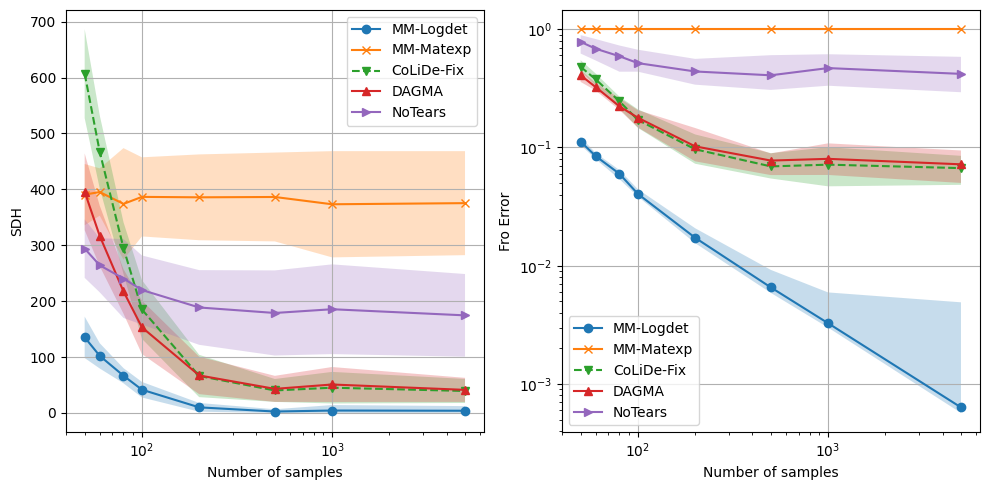

In [12]:
if SAVE:
    file_name = PATH + f'samples_{N}N_{int(data_p["edges"]/N)}_large_edges'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=N_samples)
    print('SAVED in file:', file_name)

skip = [1, 4]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
utils.plot_data(axes[0], shd, Exps, N_samples, 'Number of samples', 'SDH', skip,
                agg='mean', deviation='std', alpha=0.25)
utils.plot_data(axes[1], err, Exps, N_samples, 'Number of samples', 'Fro Error', skip,
                agg='median', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()



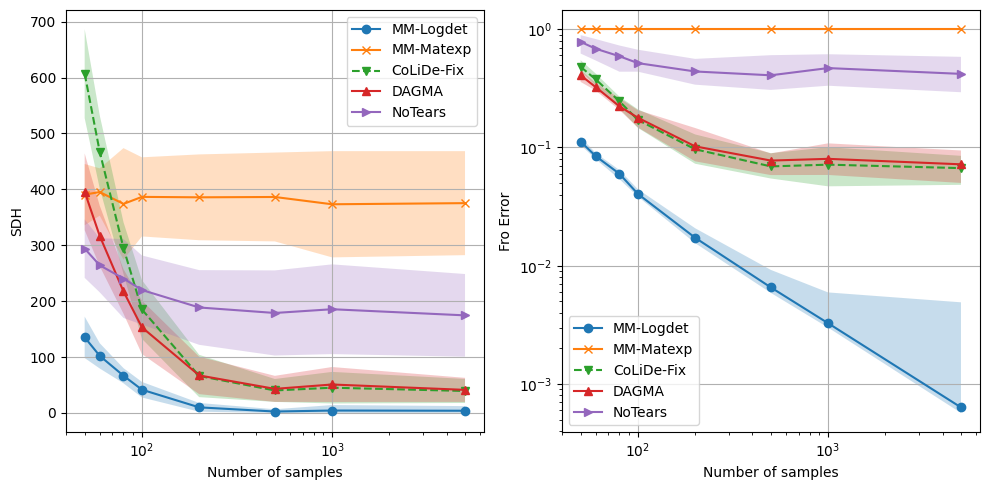

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
utils.plot_data(axes[0], shd, Exps, N_samples, 'Number of samples', 'SDH', skip,
                agg='mean', deviation='std', alpha=0.25)
utils.plot_data(axes[1], err, Exps, N_samples, 'Number of samples', 'Fro Error', skip,
                agg='median', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()

# utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
#                  skip_idx=skip, agg='median', dev=True)


### 50 nodes

In [14]:
N = 50
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,  #/np.sqrt(N),
}


shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3} minutes -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results)


CPUs employed: 64
Graph: 1, samples: 50
Graph: 2, samples: 50
Graph: 3, samples: 50
Graph: 4, samples: 50
Graph: 5, samples: 50
Graph: 6, samples: 50
Graph: 7, samples: 50
Graph: 8, samples: 50
Graph: 9, samples: 50
Graph: 10, samples: 50
Graph: 11, samples: 50
Graph: 12, samples: 50
Graph: 13, samples: 50
Graph: 14, samples: 50
Graph: 16, samples: 50
Graph: 37, samples: 50
Graph: 38, samples: 50
Graph: 35, samples: 50
Graph: 18, samples: 50
Graph: 41, samples: 50
Graph: 28, samples: 50
Graph: 22, samples: 50
Graph: 48, samples: 50
Graph: 27, samples: 50
Graph: 29, samples: 50
Graph: 19, samples: 50
Graph: 17, samples: 50
Graph: 15, samples: 50
Graph: 42, samples: 50
Graph: 25, samples: 50
Graph: 31, samples: 50
Graph: 34, samples: 50
Graph: 45, samples: 50
Graph: 36, samples: 50
Graph: 32, samples: 50
Graph: 33, samples: 50
Graph: 47, samples: 50
Graph: 40, samples: 50
Graph: 46, samples: 50
Graph: 21, samples: 50
Graph: 23, samples: 50
Graph: 44, samples: 50
Graph: 39, samples: 50
Gr

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


		-MM-Matexp: shd 36.0  -  err: 0.122  -  time: 15.659
		-CoLiDe-Fix: shd 164.0  -  err: 0.461  -  time: 7.135
		-MM-Logdet-fix: shd 53.0  -  err: 0.203  -  time: 18.294
		-MM-Matexp: shd 63.0  -  err: 0.271  -  time: 18.166
		-MM-Matexp: shd 68.0  -  err: 0.222  -  time: 14.787
		-MM-Matexp: shd 66.0  -  err: 0.224  -  time: 15.656
		-CoLiDe-Fix: shd 178.0  -  err: 0.499  -  time: 8.159
		-CoLiDe: shd 350.0  -  err: 0.599  -  time: 7.602
		-CoLiDe-Fix: shd 166.0  -  err: 0.486  -  time: 10.319
		-CoLiDe-Fix: shd 213.0  -  err: 0.676  -  time: 8.657
		-MM-Matexp: shd 52.0  -  err: 0.233  -  time: 12.981
		-MM-Matexp: shd 69.0  -  err: 0.256  -  time: 17.522
		-MM-Matexp: shd 51.0  -  err: 0.177  -  time: 16.458
		-MM-Matexp: shd 53.0  -  err: 0.231  -  time: 16.982
		-CoLiDe: shd 409.0  -  err: 0.730  -  time: 6.389
		-MM-Matexp: shd 60.0  -  err: 0.233  -  time: 18.966
		-DAGMA: shd 148.0  -  err: 0.439  -  time: 5.563
		-CoLiDe-Fix: shd 165.0  -  err: 0.436  -  time: 10.654
		-MM-Mat

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


		-NoTears: shd 132.0  -  err: 0.735  -  time: 8.573
Graph: 10, samples: 60
		-MM-Logdet: shd 32.0  -  err: 0.094  -  time: 8.378
		-MM-Logdet: shd 34.0  -  err: 0.124  -  time: 14.211
		-MM-Matexp: shd 47.0  -  err: 0.171  -  time: 14.471
		-MM-Logdet: shd 42.0  -  err: 0.131  -  time: 8.894
		-MM-Matexp: shd 55.0  -  err: 0.195  -  time: 18.678
		-MM-Logdet: shd 38.0  -  err: 0.105  -  time: 6.323
		-MM-Matexp: shd 87.0  -  err: 0.294  -  time: 24.048
		-DAGMA: shd 148.0  -  err: 0.524  -  time: 10.339
		-MM-Logdet: shd 27.0  -  err: 0.111  -  time: 11.350
		-MM-Logdet-fix: shd 36.0  -  err: 0.187  -  time: 6.322
		-DAGMA: shd 137.0  -  err: 0.476  -  time: 10.831
		-CoLiDe-Fix: shd 120.0  -  err: 0.345  -  time: 11.257
		-MM-Matexp: shd 47.0  -  err: 0.195  -  time: 13.311
		-CoLiDe-Fix: shd 105.0  -  err: 0.329  -  time: 9.836
		-MM-Matexp: shd 59.0  -  err: 0.224  -  time: 16.081
		-CoLiDe-Fix: shd 143.0  -  err: 0.413  -  time: 6.810
		-MM-Logdet-fix: shd 32.0  -  err: 0.121  -  

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


		-CoLiDe-Fix: shd 120.0  -  err: 0.429  -  time: 13.945
		-NoTears: shd 96.0  -  err: 0.501  -  time: 8.224
Graph: 17, samples: 100
		-CoLiDe-Fix: shd 89.0  -  err: 0.297  -  time: 13.162
		-MM-Logdet-fix: shd 21.0  -  err: 0.123  -  time: 5.772
		-CoLiDe-Fix: shd 117.0  -  err: 0.351  -  time: 7.354
		-MM-Logdet: shd 23.0  -  err: 0.081  -  time: 11.749
		-MM-Matexp: shd 33.0  -  err: 0.115  -  time: 28.509
		-NoTears: shd 134.0  -  err: 0.744  -  time: 6.538
Graph: 15, samples: 80
		-MM-Logdet-fix: shd 28.0  -  err: 0.116  -  time: 8.301
		-NoTears: shd 85.0  -  err: 0.489  -  time: 7.555
Graph: 48, samples: 100
		-DAGMA: shd 88.0  -  err: 0.287  -  time: 9.314
		-NoTears: shd 96.0  -  err: 0.554  -  time: 7.164
Graph: 11, samples: 100
		-MM-Logdet-fix: shd 26.0  -  err: 0.133  -  time: 11.365
		-MM-Logdet: shd 27.0  -  err: 0.090  -  time: 13.601
		-DAGMA: shd 86.0  -  err: 0.304  -  time: 5.769


/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


		-MM-Logdet: shd 21.0  -  err: 0.082  -  time: 8.307
		-CoLiDe-Fix: shd 109.0  -  err: 0.338  -  time: 9.781
		-DAGMA: shd 81.0  -  err: 0.257  -  time: 7.026
		-MM-Logdet: shd 12.0  -  err: 0.065  -  time: 9.110
		-CoLiDe: shd 216.0  -  err: 0.437  -  time: 11.119
		-DAGMA: shd 43.0  -  err: 0.179  -  time: 9.390
		-MM-Matexp: shd 52.0  -  err: 0.155  -  time: 10.755
		-MM-Logdet: shd 17.0  -  err: 0.081  -  time: 11.973
		-DAGMA: shd 55.0  -  err: 0.248  -  time: 8.433
		-CoLiDe: shd 206.0  -  err: 0.354  -  time: 8.632
		-MM-Logdet-fix: shd 41.0  -  err: 0.154  -  time: 6.315
		-MM-Matexp: shd 26.0  -  err: 0.104  -  time: 7.626
		-NoTears: shd 95.0  -  err: 0.602  -  time: 9.450
Graph: 39, samples: 80
		-CoLiDe: shd 288.0  -  err: 0.505  -  time: 15.349
		-DAGMA: shd 89.0  -  err: 0.290  -  time: 5.952
		-DAGMA: shd 159.0  -  err: 0.516  -  time: 12.115
		-CoLiDe-Fix: shd 79.0  -  err: 0.267  -  time: 9.661
		-CoLiDe-Fix: shd 107.0  -  err: 0.347  -  time: 10.244
		-MM-Logdet: shd

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


		-NoTears: shd 81.0  -  err: 0.424  -  time: 10.487
Graph: 48, samples: 200
		-MM-Logdet-fix: shd 5.0  -  err: 0.050  -  time: 5.080
		-MM-Logdet-fix: shd 16.0  -  err: 0.093  -  time: 7.000
		-MM-Logdet-fix: shd 21.0  -  err: 0.092  -  time: 11.169
		-MM-Logdet-fix: shd 4.0  -  err: 0.038  -  time: 5.400
		-CoLiDe: shd 215.0  -  err: 0.374  -  time: 15.137
		-CoLiDe-Fix: shd 120.0  -  err: 0.365  -  time: 10.305
		-CoLiDe: shd 190.0  -  err: 0.429  -  time: 6.593
		-MM-Matexp: shd 44.0  -  err: 0.193  -  time: 10.516
		-MM-Logdet-fix: shd 16.0  -  err: 0.101  -  time: 11.353
		-DAGMA: shd 66.0  -  err: 0.224  -  time: 8.116
		-MM-Logdet-fix: shd 15.0  -  err: 0.076  -  time: 8.191
		-CoLiDe: shd 227.0  -  err: 0.413  -  time: 15.092
		-CoLiDe-Fix: shd 62.0  -  err: 0.225  -  time: 13.863
		-MM-Logdet: shd 18.0  -  err: 0.086  -  time: 11.201
		-MM-Logdet: shd 18.0  -  err: 0.064  -  time: 8.680
		-MM-Logdet-fix: shd 15.0  -  err: 0.084  -  time: 8.656
		-NoTears: shd 88.0  -  err: 0.

SAVED in file: ./results/samples/samples_50N_4


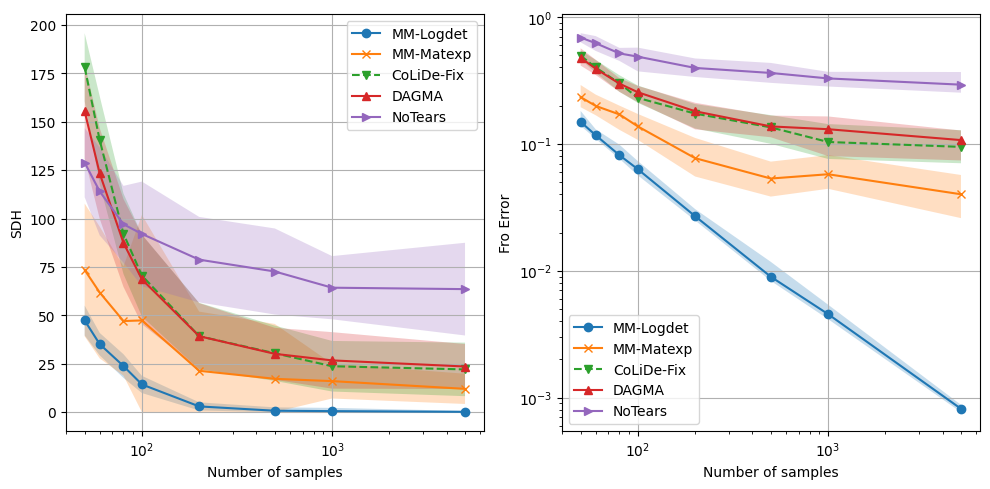

In [15]:
if SAVE:
    file_name = PATH + f'samples_{N}N_{int(data_p["edges"]/N)}'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=N_samples)
    print('SAVED in file:', file_name)

skip = [1, 4]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
utils.plot_data(axes[0], shd, Exps, N_samples, 'Number of samples', 'SDH', skip,
                agg='mean', deviation='std', alpha=0.25)
utils.plot_data(axes[1], err, Exps, N_samples, 'Number of samples', 'Fro Error', skip,
                agg='median', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()



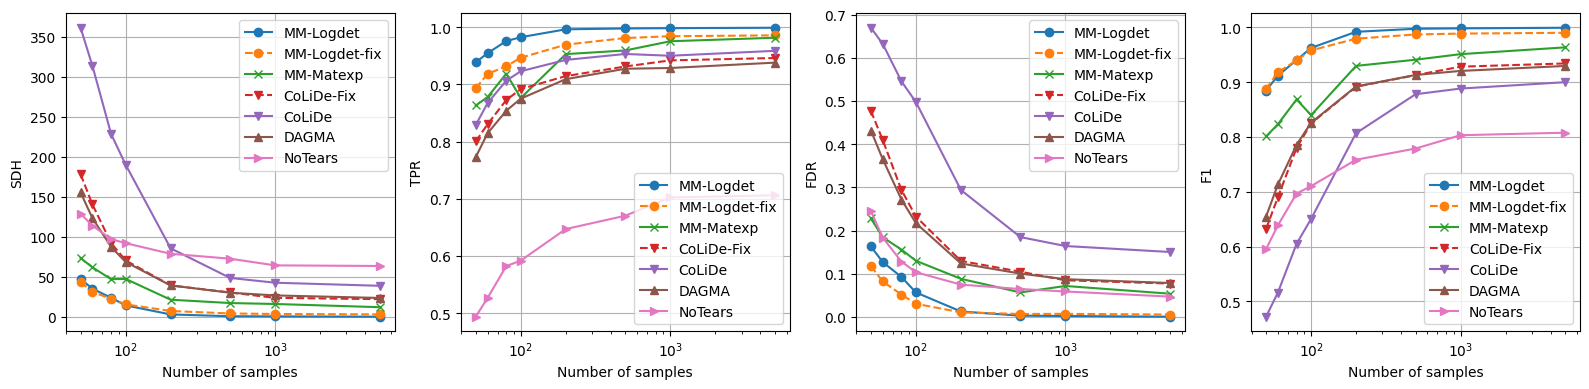

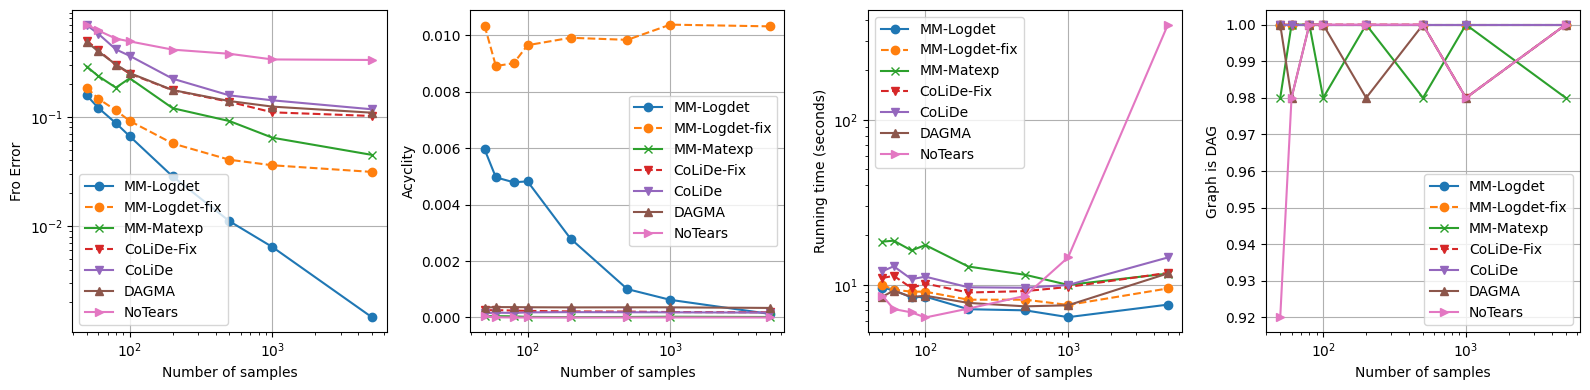

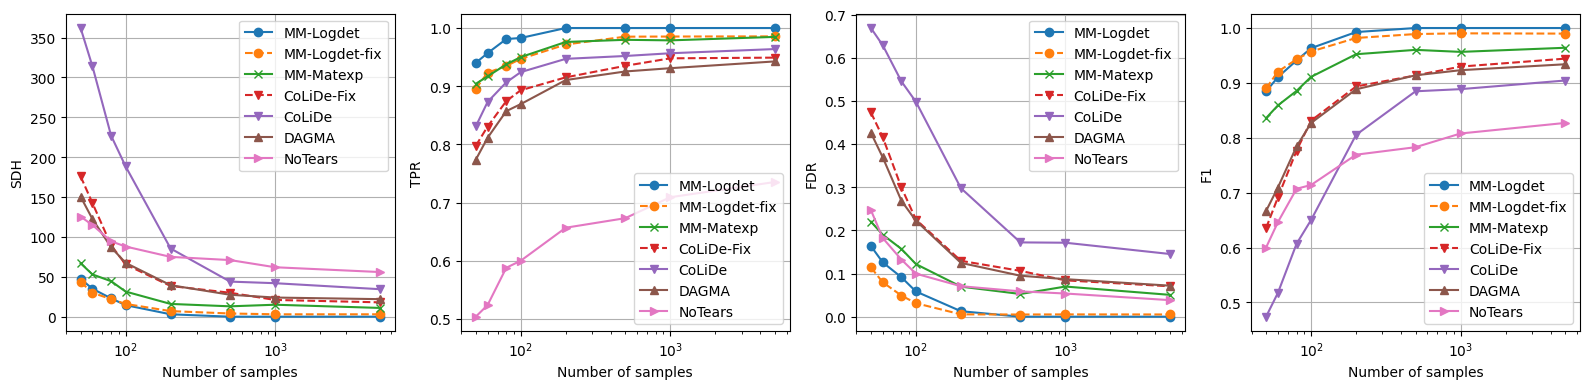

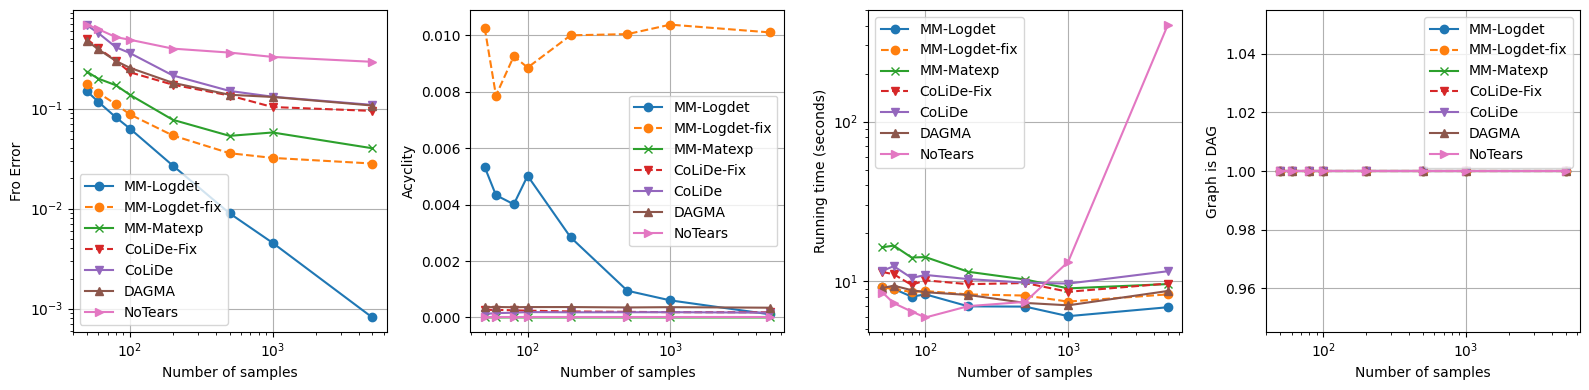

In [16]:
skip = [] # [2]
utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean')

utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='median')
